# Noise variance experiment

In [1]:
import os 
import torch

def load_all_batches(path : str, max_num_batches : int=None) -> dict[str, torch.Tensor]:
    # during inference, the samples are saved as batches 
    # this function concatenates all batches into a single list
    
    # find all files on the form batch_*.pt
    files = [f for f in os.listdir(path) if f.startswith("batch_") and f.endswith(".pt")]
    files.sort()
    if max_num_batches is not None:
        files = files[:max_num_batches]
    x0s, x1s, x0_recons, trajectories = [], [], [], []
    for file in files:
        batch = torch.load(os.path.join(path, file), weights_only=True)
        x0s.append(batch["x0"])
        x1s.append(batch["x1"])
        x0_recons.append(batch["x0_recon"])
        trajectories.append(batch["trajectory"])
    # concatenate all batches into a single tensor
    x0 = torch.cat(x0s, dim=0)
    x1 = torch.cat(x1s, dim=0)
    x0_recon = torch.cat(x0_recons, dim=0)
    if trajectories[0] is not None:
        trajectories = torch.cat(trajectories, dim=1)
    return {
        "x0": x0,
        "x1": x1,
        "x0_recon": x0_recon,
        "trajectory": trajectories
    }


model_to_name = {
    'mel_sto': 'DSB Log Mel',
    'stft_sto': 'DSB STFT',
    'stft_det': 'DSB STFT',
    'gfb': 'GFB STFT',
    'baseline': 'Baseline',
    'esdsb_sto': 'ESDSB',
    'baseline': 'Baseline',
    'esdsb_det': 'ESDSB Deterministic',
}

model_to_color = {
    'mel_sto': '#4E79A7',
    'stft_sto': '#F28E2B',
    'stft_det': '#F28E2B',
    'gfb': '#E15759',
    'esdsb_sto': '#76B7B2',
    'baseline': '#59A14F',
    'esdsb_det': '#FF9DA7',
}

In [2]:
from IPython.display import Audio, display
for model in ['sepformer', 'esdsb_sto_30']:
    print(model)
    batches = load_all_batches(f'/work3/s214630/Latent-DSB/test_results/test_noise/{model}', max_num_batches=1)
    metrics = torch.load(f'/work3/s214630/Latent-DSB/test_results/test_noise/{model}/metrics.pt')
    
    x0, x1, x0_recon = batches['x0'], batches['x1'], batches['x0_recon']

    for i in range(1):
        # display(Audio(x0[i].flatten(), rate=16000))
        # display(Audio(x1[i].flatten(), rate=16000))
        display(Audio(x0_recon[i].flatten(), rate=16000))
    
    for metric, values in metrics.items():
        values = torch.tensor(values)
        print(metric, values.mean())
    print("."*30)

sepformer


/tmp/ipykernel_651322/2442862496.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics = torch.load(f'/work3/s214630/Latent-DSB/test_results/test_noise/{model}/metrics

wer tensor(0.3991)
srcs tensor(0.4666)
dnsmos tensor(2.2802)
kad tensor(11.7959)
snr tensor(1.3763)
..............................
esdsb_sto_30


wer tensor(0.3759)
srcs tensor(0.5356)
dnsmos tensor(3.2328)
kad tensor(4.6510)
snr tensor(-29.4942)
..............................


/tmp/ipykernel_651322/2753644923.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics = torch.load(f'/work3/s214630/Latent-DSB/test_results/test_noise/sepformer/metri

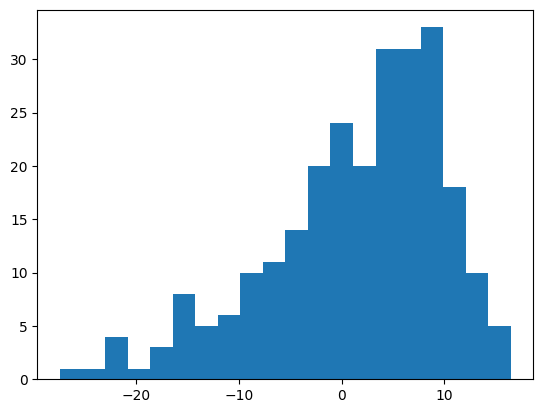

In [3]:
import matplotlib.pyplot as plt
metrics = torch.load(f'/work3/s214630/Latent-DSB/test_results/test_noise/sepformer/metrics.pt')
snr = metrics['snr']
plt.hist(snr,bins=20)
plt.show()

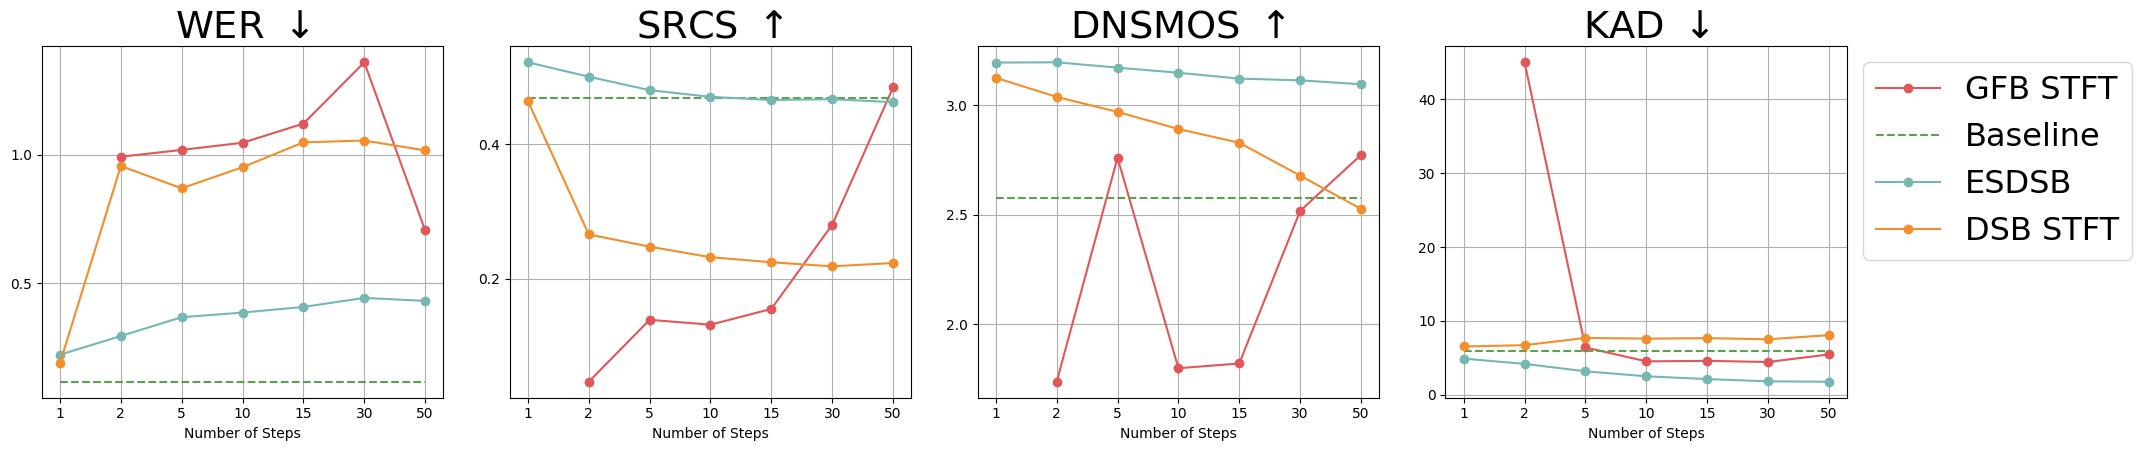

In [4]:
import matplotlib.pyplot as plt
import torch

data = dict()
what_test = "clip"

num_steps = [1, 2, 5, 10, 15, 30, 50]  # reversed order for plotting
for model in ['gfb', 'baseline', 'esdsb_sto', 'stft_sto']:
    data[model] = dict()
    for metric in ['wer', 'srcs', 'dnsmos', 'kad']:
        metric_dict = dict()
        for num_step in num_steps:
            if num_step == 1 and model == 'gfb':
                continue
            
            if model == 'baseline':
                path = f"test_results/test_{what_test}/baseline"
            else:
                path = f"test_results/test_{what_test}/{model}_{num_step}"
                
            metrics = torch.load(path + "/metrics.pt", weights_only=True)
            value = metrics[metric]
            value = torch.tensor(value)
            value = value.mean().item()
            
            metric_dict[num_step] = value
            
            if model == 'baseline':
                break

        data[model][metric] = metric_dict

fig, axs = plt.subplots(1, 4, figsize=(22, 5))
axs : list[plt.Axes]
plt.rcParams.update({'font.size': 23})

for i, (model, metrics) in enumerate(data.items()):    
    if model == 'baseline':
        axs[0].hlines(y=metrics['wer'].values(), linestyles='--', xmin=0, xmax=len(num_steps)-1, color=model_to_color[model])
        axs[1].hlines(y=metrics['srcs'].values(), linestyles='--', xmin=0, xmax=len(num_steps)-1, color=model_to_color[model])
        axs[2].hlines(y=metrics['dnsmos'].values(), linestyles='--', xmin=0, xmax=len(num_steps)-1, color=model_to_color[model])
        axs[3].hlines(y=metrics['kad'].values(), linestyles='--', xmin=0, xmax=len(num_steps)-1, color=model_to_color[model], label=model_to_name[model])
        continue
    
    xvalues = range(len(num_steps)) if model != 'gfb' else range(1, len(num_steps))  # GFB does not have num_step=1
    axs[0].plot(xvalues, metrics['wer'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[1].plot(xvalues, metrics['srcs'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[2].plot(xvalues, metrics['dnsmos'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[3].plot(xvalues, metrics['kad'].values(), marker='o', linestyle='-', color=model_to_color[model], label=model_to_name[model])
for i in range(4):
    axs[i].set_xlabel("Number of Steps")
    axs[i].set_title([r"WER $\downarrow$", r"SRCS $\uparrow$", r"DNSMOS $\uparrow$", r"KAD $\downarrow$"][i])
    axs[i].grid(True)
    axs[i].set_xticks(range(len(num_steps)))
    axs[i].set_xticklabels(num_steps)
    if i == 3:
        axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"test_results/test_{what_test}/metrics.png", bbox_inches='tight', dpi=300)
plt.show()


In [24]:
# make it easy to copy paste the results to txt file
import torch

n_decimals = 2

what_test = 'rir'
which_models = {
    'esdsb_sto_1': 'DSB Mel (1 step)',
    'esdsb_sto_50': 'DSB Mel (50 steps)',
    'esdsb_det_50': 'DSB Mel Deterministic (50 steps)',
    'stft_sto_1': 'DSB STFT (1 step)',
    'stft_sto_50': 'DSB STFT (50 steps)',
    'gfb_2': 'GFB (2 steps)',
    'gfb_50': 'GFB (50 steps)',
    'baseline': 'Baseline',
}

for model in which_models:
    metrics = torch.load(f"test_results/test_{what_test}/{model}/metrics.pt", weights_only=False)
    mos = torch.tensor(metrics['dnsmos']).mean().item()
    wer = torch.tensor(metrics['wer']).mean().item()
    srcs = torch.tensor(metrics['srcs']).mean().item()
    kad = torch.tensor(metrics['kad']).mean().item()

    print(f"{which_models[model]} & {mos:.{n_decimals}f} & {wer:.{n_decimals}f} & {srcs:.{n_decimals}f} & {kad:.{n_decimals}f} \\\\")

DSB Mel (1 step) & 3.22 & 0.32 & 0.52 & 5.71 \\
DSB Mel (50 steps) & 3.16 & 0.59 & 0.46 & 3.59 \\
DSB Mel Deterministic (50 steps) & 3.11 & 0.48 & 0.41 & 7.38 \\
DSB STFT (1 step) & 2.69 & 0.87 & 0.30 & 6.57 \\
DSB STFT (50 steps) & 2.86 & 1.33 & 0.19 & 6.98 \\
GFB (2 steps) & 1.64 & 0.99 & 0.01 & 27.40 \\
GFB (50 steps) & 2.83 & 0.87 & 0.41 & 6.22 \\
Baseline & 2.02 & 0.17 & 0.52 & 4.51 \\


In [26]:
# make it easy to copy paste the results to txt file
import torch

n_decimals = 2

what_test = 'noise'
which_models = {
    'esdsb_sto_1': 'DSB Mel (1 step)',
    'esdsb_sto_50': 'DSB Mel (50 steps)',
    'sepformer': 'Sepformer',
    'baseline': 'Baseline',
}

for model in which_models:
    metrics = torch.load(f"test_results/test_{what_test}/{model}/metrics.pt", weights_only=False)
    mos = torch.tensor(metrics['dnsmos']).mean().item()
    wer = torch.tensor(metrics['wer']).mean().item()
    kad = torch.tensor(metrics['kad']).mean().item()
    srcs = torch.tensor(metrics['srcs']).mean().item()

    print(f"{which_models[model]} & {mos:.{n_decimals}f} & {wer:.{n_decimals}f} & {srcs:.{n_decimals}f} & {kad:.{n_decimals}f} \\\\")

DSB Mel (1 step) & 3.26 & 0.31 & 0.63 & 5.85 \\
DSB Mel (50 steps) & 3.22 & 0.38 & 0.53 & 4.42 \\
Sepformer & 2.28 & 0.40 & 0.47 & 11.80 \\
Baseline & 2.04 & 0.06 & 0.88 & 3.02 \\


tensor([0.0000e+00, 9.8664e-04, 3.9426e-03, 8.8564e-03, 1.5708e-02, 2.4472e-02,
        3.5112e-02, 4.7586e-02, 6.1847e-02, 7.7836e-02, 9.5491e-02, 1.1474e-01,
        1.3552e-01, 1.5773e-01, 1.8129e-01, 2.0611e-01, 2.3209e-01, 2.5912e-01,
        2.8711e-01, 3.1594e-01, 3.4549e-01, 3.7566e-01, 4.0631e-01, 4.3733e-01,
        4.6860e-01, 5.0000e-01, 5.3140e-01, 5.6267e-01, 5.9369e-01, 6.2434e-01,
        6.5451e-01, 6.8406e-01, 7.1289e-01, 7.4088e-01, 7.6791e-01, 7.9389e-01,
        8.1871e-01, 8.4227e-01, 8.6448e-01, 8.8526e-01, 9.0451e-01, 9.2216e-01,
        9.3815e-01, 9.5241e-01, 9.6489e-01, 9.7553e-01, 9.8429e-01, 9.9114e-01,
        9.9606e-01, 9.9901e-01, 1.0000e+00])
tensor([0.0000e+00, 9.8664e-04, 3.9426e-03, 8.8564e-03, 1.5708e-02, 2.4472e-02,
        3.5112e-02, 4.7586e-02, 6.1847e-02, 7.7836e-02, 9.5491e-02, 1.1474e-01,
        1.3552e-01, 1.5773e-01, 1.8129e-01, 2.0611e-01, 2.3209e-01, 2.5912e-01,
        2.8711e-01, 3.1594e-01, 3.4549e-01, 3.7566e-01, 4.0631e-01, 4.3733e

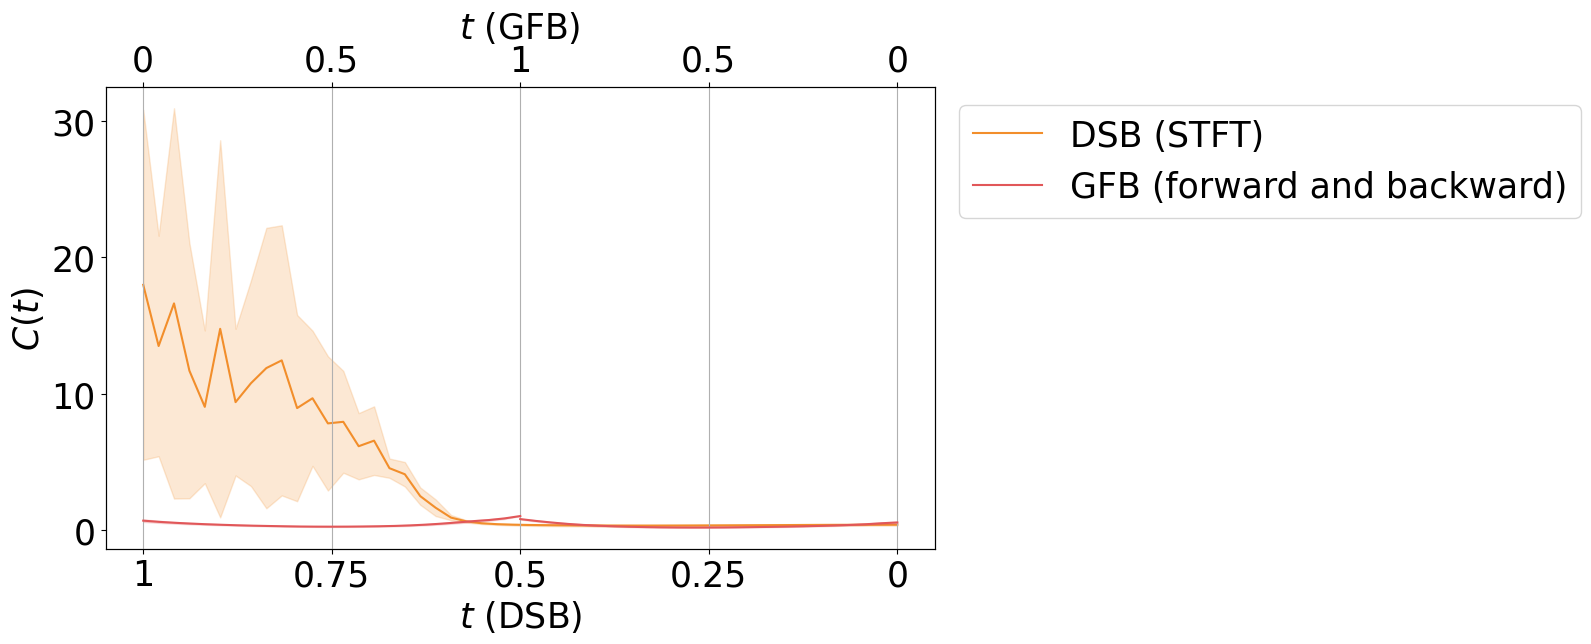

In [ ]:
# investigate trajectory curvature

import torch
from src.callbacks.metrics import calculate_curvature_displacement
from torch import Tensor

def calculate_gfb_curvature_from_path(path : str, max_num_batches : int, direction : str) -> tuple[Tensor, Tensor]:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    timeschedule = torch.cat([torch.tensor([0.0]), timeschedule], dim=0)
    trajectories = batches['trajectory']
    forward_trajectory, backwrd_trajectory = trajectories.chunk(2, dim=0)
    
    if direction == 'forward':
        return calculate_curvature_displacement(forward_trajectory, timeschedule), timeschedule
    elif direction == 'backward':
        return calculate_curvature_displacement(backwrd_trajectory, timeschedule), timeschedule

def calculate_dsb_curvature_from_path(path : str, max_num_batches : int) -> Tensor:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    
    if isinstance(timeschedule, list):
        timeschedule = [t for t, _ in timeschedule] + [timeschedule[-1][1]]
        timeschedule = torch.tensor(timeschedule).flip(dims=[0])
        print(timeschedule)

    trajectories = batches['trajectory']
    return calculate_curvature_displacement(trajectories, timeschedule), timeschedule

models = ['gfb', 'stft']
data : dict[str, tuple[Tensor, Tensor]] = dict()
n_batches = 1

for model in models:
    data[model] = dict()

    path = f"test_results/test_traj/{model}"
    
    if model == 'gfb':
        cts_forward, timeschedule = calculate_gfb_curvature_from_path(path, max_num_batches=n_batches, direction='forward')
        cts_backward, _ = calculate_gfb_curvature_from_path(path, max_num_batches=n_batches, direction='backward')
        data['gfb_forward'] = cts_forward, timeschedule
        data['gfb_backward'] = cts_backward, timeschedule
    else:
        cts, timeschedule = calculate_dsb_curvature_from_path(path, max_num_batches=n_batches)
        data['dsb'] = cts, timeschedule


import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(10, 7))

stft_traj = data['dsb'][0]
stft_traj = stft_traj.flip(dims=[1])
stft_mean = stft_traj.mean(dim=0)
stft_std = stft_traj.std(dim=0)
timeschedule = torch.linspace(0, 1, steps=stft_traj.shape[1])  # create a timeschedule from 0 to 1

ax.plot(timeschedule, stft_mean, label="DSB (STFT)", color=model_to_color['stft_det'])
ax.fill_between(timeschedule, stft_mean - stft_std, stft_mean + stft_std, alpha=0.2, color=model_to_color['stft_det'])

ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels([1, 0.75, 0.5, 0.25, 0])
ax.set_xlabel("$t$ (DSB)")

ax2 = ax.twiny()  # create a second y-axis

forward_traj = data['gfb_forward'][0]
backward_traj = data['gfb_backward'][0]
timeschedule = torch.linspace(0, 1, steps=forward_traj.shape[1])  # create a timeschedule from 0 to 1

forward_mean = forward_traj.mean(dim=0)
forward_std = forward_traj.std(dim=0)
backward_mean = backward_traj.mean(dim=0)
backward_std = backward_traj.std(dim=0)

ax2.plot(timeschedule, forward_mean, color=model_to_color['gfb'])
ax2.plot(timeschedule + 1, backward_mean, label="GFB (forward and backward)", color=model_to_color['gfb'])
ax2.fill_between(timeschedule, forward_mean - forward_std, forward_mean + forward_std, alpha=0.2, color=model_to_color['gfb'])
ax2.fill_between(timeschedule + 1, backward_mean - backward_std, backward_mean + backward_std, alpha=0.2, color=model_to_color['gfb'])

# right now, x-axis goes from 0 to 2
# make the ticks look like they go from 0 to 1 and back to 0
ax2.set_xticks([0, 0.5, 1, 1.5, 2])
ax2.set_xticklabels([0, 0.5, 1, 0.5, 0])

ax2.set_xlabel("$t$ (GFB)")

ax.set_ylabel("$C(t)$")
fig.legend(loc='upper right', bbox_to_anchor=(1.8, 1), bbox_transform=ax.transAxes)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"test_results/test_clip/curvature.png", bbox_inches='tight', dpi=300)
plt.show()

In [177]:
path = '/work3/s214630/Latent-DSB/test_results/test_traj/gfb'
batch = load_all_batches(path, max_num_batches=1)
params = torch.load(path + "/params.pt", weights_only=True)
timeschedule = params['timeschedule']
trajectory = batch['trajectory']
print(trajectory.shape)

torch.Size([52, 16, 1, 65536])


In [ ]:
# make it easy to copy paste the results to txt file
import torch

n_decimals = 2

what_test = 'rir'
which_models = {
    'esdsb_sto_1': 'DSB Mel (1 step)',
    'esdsb_sto_50': 'DSB Mel (50 steps)',
    'esdsb_det_50': 'DSB Mel Deterministic (50 steps)',
    'stft_sto_1': 'DSB STFT (1 step)',
    'stft_sto_50': 'DSB STFT (50 steps)',
    'gfb_2': 'GFB (2 steps)',
    'gfb_50': 'GFB (50 steps)',
    'baseline': 'Baseline',
}

for model in which_models:
    metrics = torch.load(f"test_results/test_{what_test}/{model}/metrics.pt", weights_only=False)
    mos = torch.tensor(metrics['dnsmos']).mean().item()
    wer = torch.tensor(metrics['wer']).mean().item()
    srcs = torch.tensor(metrics['srcs']).mean().item()
    kad = torch.tensor(metrics['kad']).mean().item()

    print(f"{which_models[model]} & {mos:.{n_decimals}f} & {wer:.{n_decimals}f} & {srcs:.{n_decimals}f} & {kad:.{n_decimals}f} \\\\")

DSB Mel (1 step) & 3.22 & 0.32 & 0.52 & 5.71 \\
DSB Mel (50 steps) & 3.16 & 0.59 & 0.46 & 3.59 \\
DSB Mel Deterministic (50 steps) & 3.11 & 0.48 & 0.41 & 7.38 \\
DSB STFT (1 step) & 2.69 & 0.87 & 0.30 & 6.57 \\
DSB STFT (50 steps) & 2.86 & 1.33 & 0.19 & 6.98 \\
GFB (2 steps) & 1.64 & 0.99 & 0.01 & 27.40 \\
GFB (50 steps) & 2.83 & 0.87 & 0.41 & 6.22 \\
Baseline & 2.02 & 0.17 & 0.52 & 4.51 \\


In [49]:
import os
import torchaudio

path = "/work3/s214630/Latent-DSB/audio_samples/"
os.makedirs(path, exist_ok=True)
n_samples = 5

for experiment in ['clip', 'rir']:
    for model in ['baseline', 'mel_sto', 'stft_sto', 'gfb']:
        if model == 'baseline':
            samples_path = f"test_results/test_{experiment}/baseline"
            batches = load_all_batches(samples_path, max_num_batches=3)
            x0 = batches['x0']
            x1 = batches['x1']
            for i in range(n_samples):
                torchaudio.save(os.path.join(path, f"{experiment}_{model}_x0_{i}.wav"), x0[i].squeeze().unsqueeze(0), 16000)
                torchaudio.save(os.path.join(path, f"{experiment}_{model}_x1_{i}.wav"), x1[i].squeeze().unsqueeze(0), 16000)
            
        else:
            if model == 'gfb':
                num_steps = [30]
            else:
                num_steps = [30, 1]
            
            for num_step in num_steps:
                samples_path = f"test_results/test_{experiment}/{model}_{num_step}"
                batches = load_all_batches(samples_path, max_num_batches=1)
                x0_recon = batches['x0_recon']
                for i in range(n_samples):
                    torchaudio.save(os.path.join(path, f"{experiment}_{model}_{num_step}_x0_recon_{i}.wav"), x0_recon[i].squeeze().unsqueeze(0), 16000)
            

In [178]:
# test noise factor
import torch

xs = [i / 10 for i in range(21)]
data = torch.zeros((21, 4))
for i, noise_factor in enumerate(xs):
    path = f'/work3/s214630/Latent-DSB/test_results/test_noise_factor/esdsb_sto_{noise_factor}'
    metrics = torch.load(path + "/metrics.pt", weights_only=False)
    metric_values = []
    for metric in ['wer', 'srcs', 'dnsmos', 'kad']:
        value = metrics[metric]
        value = torch.tensor(value)
        value = value.mean().item()
        metric_values.append(value)
    data[i] = torch.tensor(metric_values)


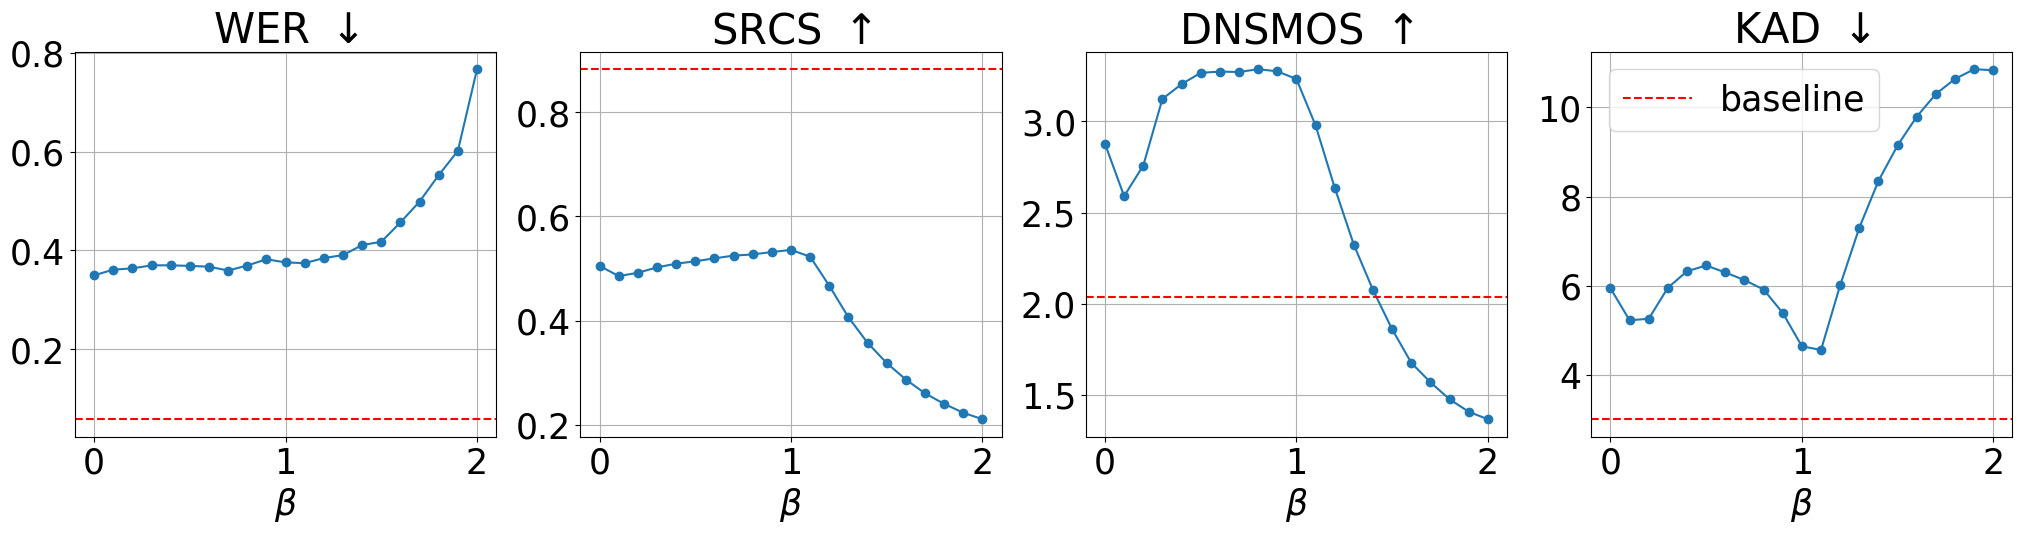

In [197]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(25, 5))
axs : list[plt.Axes]

plt.rcParams.update({'font.size': 25})

baseline = torch.load('/work3/s214630/Latent-DSB/test_results/test_noise/baseline/metrics.pt', weights_only=False)


for i, metric in enumerate(['WER', 'SRCS', 'DNSMOS', 'KAD']):
    title = [r"WER $\downarrow$", r"SRCS $\uparrow$", r"DNSMOS $\uparrow$", r"KAD $\downarrow$"][i]
    axs[i].plot(xs, data[:, i], marker='o')
    axs[i].set_title(title)
    axs[i].grid(True)
    axs[i].set_xlabel(r'$\beta$')
    
    if metric == 'WER':
        baseline_val = torch.tensor(baseline['wer']).mean().item()
    if metric == 'SRCS':
        baseline_val = torch.tensor(baseline['srcs']).mean().item()
    if metric == 'DNSMOS':
        baseline_val = torch.tensor(baseline['dnsmos']).mean().item()
    if metric == 'KAD':
        baseline_val = torch.tensor(baseline['kad']).mean().item()
        
    label = 'baseline' if i == 3 else None
    axs[i].axhline(y=baseline_val, linestyle='--', color='r', label=label)

plt.legend(loc='upper left', fontsize=25)